In [172]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import itertools

import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.externals import joblib
from lessonFunctions import *


%matplotlib inline


### Load training data from pickle

In [173]:
data = joblib.load('models/svc_01.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
svc = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
X_scaler = config['X_scaler']
print(config)

{'pix_per_cell': 8, 'hog_feat': True, 'spatial_size': (32, 32), 'hog_channel': 0, 'spatial_feat': False, 'hist_feat': False, 'color_space': 'GRAY', 'cell_per_block': 4, 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hist_bins': 32, 'orient': 14}


## Find cars function

In [174]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
 # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
            print(ctrans_tosearch.shape)
        elif cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
#             print(ctrans_tosearch.shape)
    else: ctrans_tosearch = np.copy(image)   
       
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
        

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles =[] #https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
# #             spatial_features = np.array(spatial_features)
# #             img_features.append(spatial_features)
            
# #             print("spatial: ", spatial_features.shape, "type: ", type(spatial_features))

#             hist_features = color_hist(subimg, nbins=hist_bins)
# #             hist_features = np.array(hist_features)
# #             img_features.append(hist_features)
            
# #             print("hist: ", hist_features.shape, "type: ", type(hist_features))

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
# #             test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))   

            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
    
# #             test_features = X_scaler.transform(np.hstack((hog_feat1)).reshape(1, -1))    

#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
#             print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# img = mpimg.imread('./test_images/test5.jpg')

    
# ystart = 400
# ystop = 600
# scale = 1.5
    
# out_img = find_cars(img, ystart, ystop, scale, svc, Xscaler, orient, pix_per_cell, cell_per_block, spatialSize, histBins)

# plt.imshow(out_img)

In [175]:
triangle = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
      ]

# print(triangle)
# print(type(triangle))
# print(len(triangle))
image_size = (720, 1280)

# img = mpimg.imread('./test_images/test5.jpg')


# vertices = np.array([[(0, image_size[0]), (0,image_size[0]/2), (image_size[1], image_size[0]/2), (image_size[1], image_size[0])]], dtype=np.int32)
# vertices = vertices.reshape((-1,1,2))
# trinagle = cv2.polylines(img,[vertices],True,(255,0,0), 4)
# plt.imshow(trinagle)
windows = create_windows(triangle, image_size)

## ...

In [204]:
from lessonFunctions import *
def process_frame(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        
#         if 'tracker' not in cache:
#             cache['tracker'] = VehicleTracker(image.shape)
#         frame_ctr = cache['frame_ctr']
#         tracker = cache['tracker']
#         cache['frame_ctr'] += 1

#         windows = all_windows[frame_ctr % len(all_windows)]# + extra
        windows = itertools.chain(*all_windows)
    else:
        windows = itertools.chain(*all_windows)

    measurements = car_detect(image, clf, config, windows, 0.9)
    current_heatmap = update_heatmap(measurements, image.shape)
    if not params['cache_enabled']:
        thresh_heatmap = current_heatmap
    else:
        cache['heatmaps'].append(current_heatmap)
        thresh_heatmap = sum(cache['heatmaps'])
    
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

    labels = label(thresh_heatmap)
    im2 = draw_labeled_bboxes(np.copy(image), labels)

#     if not params['cache_enabled']:
#         im2 = draw_labeled_bboxes(np.copy(image), labels)
#     else:
#         Z = []
#         for car_number in range(1, labels[1]+1):
#             nonzero = (labels[0] == car_number).nonzero()
#             nonzeroy = np.array(nonzero[0])
#             nonzerox = np.array(nonzero[1])
#             Z.append((np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)))
#         tracker.detect(Z)
#         im2 = tracker.draw_bboxes(np.copy(image))
        
    return im2

def clear_cache():
    process_image.cache = {
        'meas': None,
        'heatmaps': None,
        'frame_ctr': 0
    }

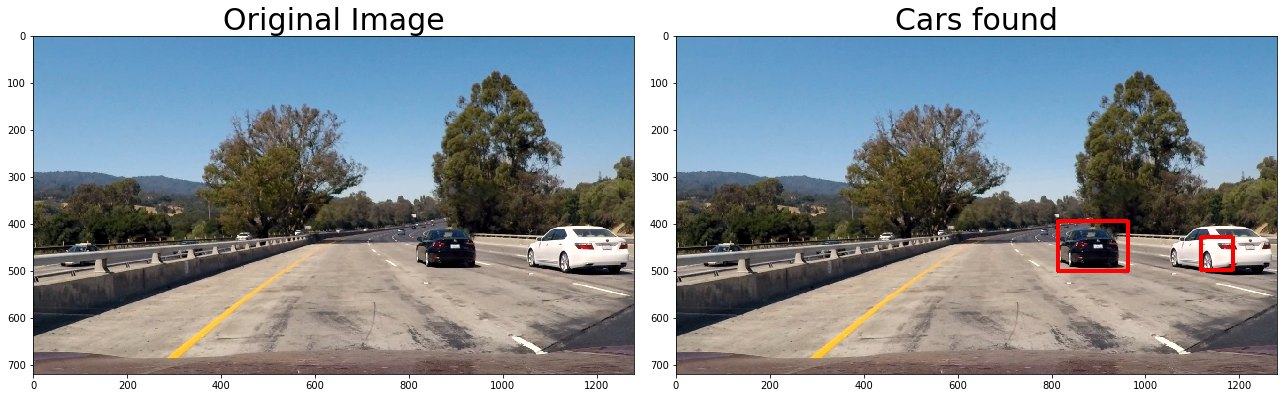

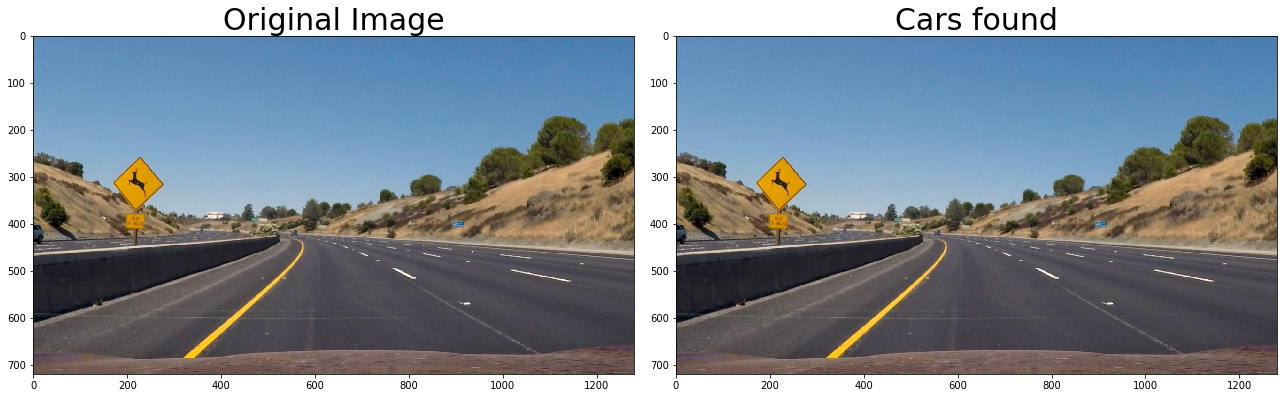

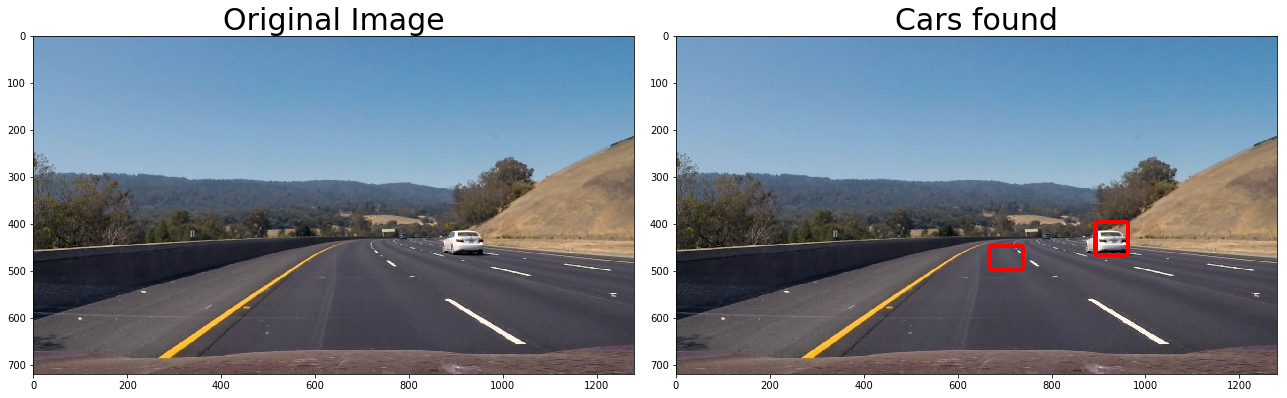

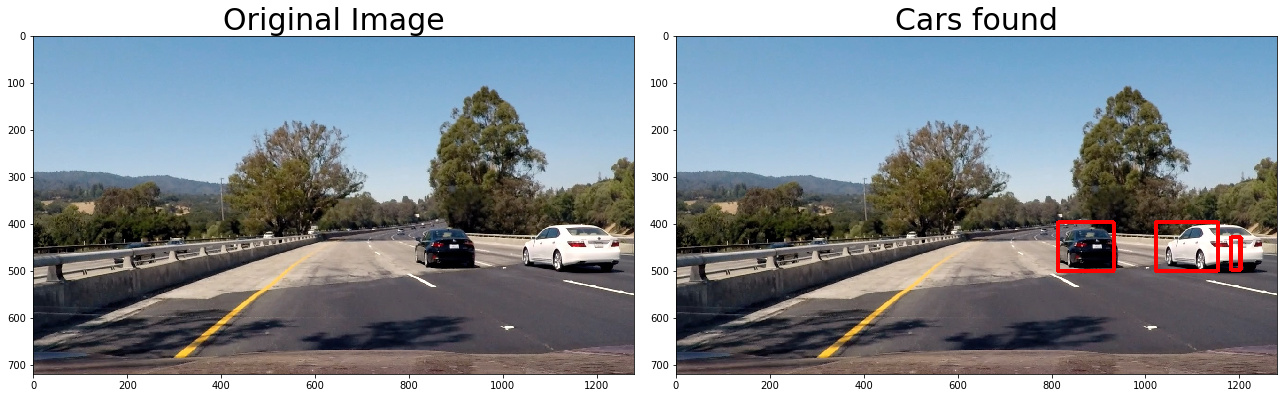

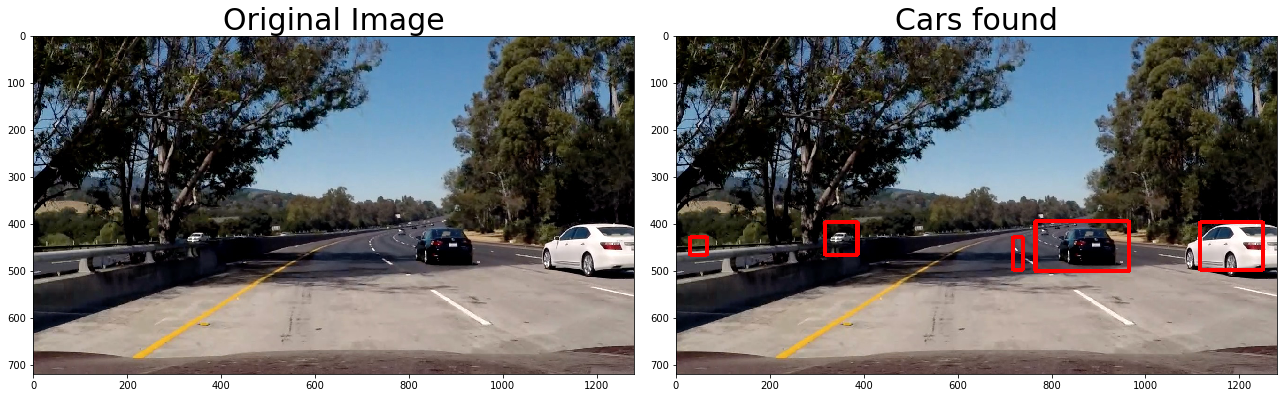

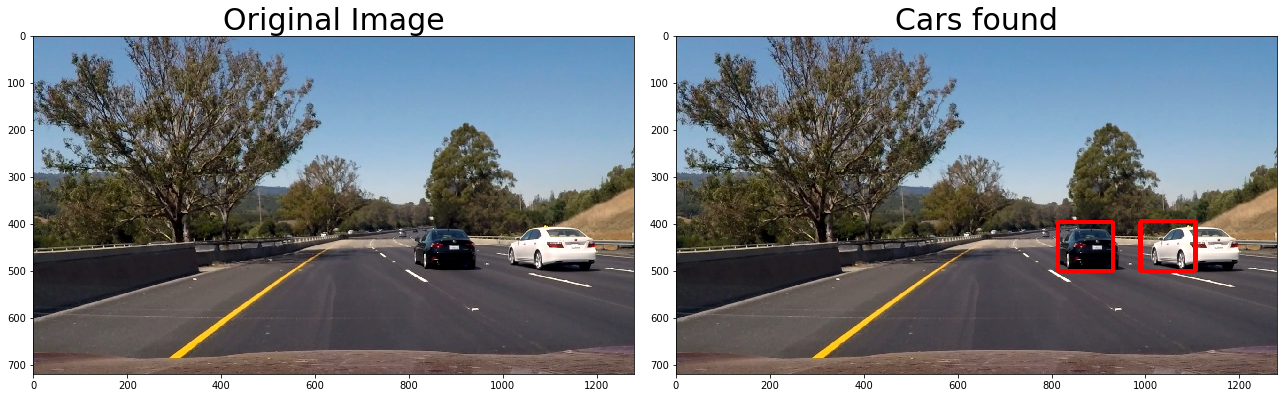

In [205]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 2

for i in range(1,7):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
    window_img = process_frame(image, params)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
#     plt.savefig('output_images/sliding_window.png', bbox_inches="tight")
    # plt.imshow(window_img)
    plt.show()
#     plt.imshow(im2)

## Function to process video with

In [209]:
clear_cache()

params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 100
params['heatmap_threshold'] = 100

t = time.time()

test_out_file = 'test_video_out.mp4'
# clip_test = VideoFileClip('test_video.mp4')
clip_test = VideoFileClip('project_video.mp4').subclip(20, 50)
# clip_test = VideoFileClip('project_video.mp4')

# clip_test_out = clip_test.fl_image(process_frame)
clip_test_out = clip_test.fl_image(lambda x: process_image(x, params))

%time clip_test_out.write_videofile(test_out_file, audio=False)

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to process video.')



[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 21%|██        | 155/751 [00:31<02:05,  4.76it/s]


 41%|████      | 309/751 [01:03<01:39,  4.46it/s]


 62%|██████▏   | 463/751 [01:35<00:59,  4.84it/s]


 82%|████████▏ | 617/751 [02:08<00:27,  4.86it/s]


100%|█████████▉| 750/751 [02:36<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min 30s, sys: 3.55 s, total: 2min 33s
Wall time: 2min 36s
157.39623 Seconds to process video.
